# Deep Learning (imagenes 3D)

## Imports

In [1]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
import math
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image
from numba import cuda
from skimage import measure 
from skimage.morphology import disk, opening, closing
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
# Hide warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Reset GPU memory
device = cuda.get_current_device()
device.reset()

In [4]:
# Seeds
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
# seed_everything()

In [5]:
# Tensorflow configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [6]:
# Base path
BASEPATH = '../osic-pulmonary-fibrosis-progression/'

# Bad ids
BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']

In [7]:
# Train dataset
train = pd.read_csv(BASEPATH + 'train.csv')

## Linear Decay

In [8]:
# Main parameters
EPOCHS = 100
BATCH_SIZE = 4
LR = 0.003
SAVE_BEST = True

In [9]:
def get_tab(df):
    
    # initialize a vector
    vector = [] 
    
    # insert normalized age
    vector.append((df.Age.values[0] - 30) / 30)
    
    # insert binary sex
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    # insert binary smoking status
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
        
    return np.array(vector)

In [10]:
# initialize variables
linear_decay_data = {} 
tab_data_converted = {} 
unique_ids = [] 

for index, patient_id in tqdm(enumerate(train.Patient.unique())):
    path = BASEPATH + "train/" + patient_id + "/"
    # select only the patients with at least 32 images
    if len(os.listdir(path)) > 32:
        sub = train.loc[train.Patient == patient_id] 
        fvc = sub.FVC.values
        weeks = sub.Weeks.values
        weeks_array = np.vstack([weeks, np.ones(len(weeks))]).T
        value, _ = np.linalg.lstsq(weeks_array, fvc)[0]
    
        linear_decay_data[patient_id] = value
        tab_data_converted[patient_id] = get_tab(sub)
        unique_ids.append(patient_id)

In [11]:
pd.DataFrame(unique_ids).head(3)

,0
0,ID00009637202177434476278
1,ID00010637202177584971671
2,ID00012637202177665765362


In [12]:
pd.DataFrame(tab_data_converted).T.sample(5)

,0,1,2,3
ID00133637202223847701934,1.766667,1.0,0.0,0.0
ID00186637202242472088675,1.300000,1.0,1.0,1.0
ID00190637202244450116191,1.300000,1.0,1.0,1.0
ID00012637202177665765362,1.166667,1.0,0.0,0.0
ID00408637202308839708961,1.466667,1.0,1.0,1.0


In [13]:
pd.DataFrame(linear_decay_data.items(),columns=["Patient Id","Linear Decay Value"]).sample(5)

,Patient Id,Linear Decay Value
41,ID00130637202220059448013,-8.003377
53,ID00168637202237852027833,-8.515749
99,ID00322637202284842245491,-6.314691
71,ID00219637202258203123958,-3.873737
89,ID00290637202279304677843,-9.107582


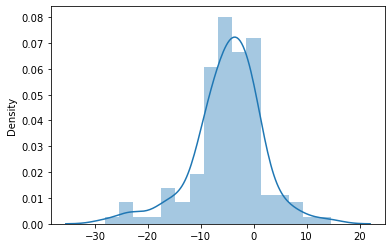

In [14]:
sns.distplot(list(linear_decay_data.values()));

## CNN 3D (128x128x64) + Linear Decay + Tabular Data

In [15]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x, a, tab = [], [], []
        keys = np.random.choice(self.keys, size = self.batch_size)
        
        for k in keys:
            try:
                img = np.load(f'../osic-pulmonary-fibrosis-progression/trainx32_segmented_scans_128x128/{k}_hu_scans.npy')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

### Creating model

In [16]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv3D, MaxPool3D, 
    LeakyReLU, Concatenate, GaussianNoise, GlobalAveragePooling3D
)

In [17]:
def get_model(width=128, height=128, depth=32):
    
    # IMAGE DATA INPUT
    inputs = Input((width, height, depth, 1))

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling3D()(x)
    x = Dense(units=256, activation="relu")(x)
    x = Dropout(0.5)(x)

    x1 = Dense(4)(x)
    
    # TABULAR DARA INPUT
    #input2 = Input(shape=(4,))
    #x2 = GaussianNoise(0.2)(input2)
    
    input2 = Input(shape=(4,))
    x2 = GaussianNoise(0.1)(input2)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(4, activation="linear")(x2)
    # x2 = Dense(1, activation="linear")(x2)
    
    # CONCATENATE
    x = Concatenate()([x1, x2]) 
    
    x = Dropout(0.3)(x) 
    x = Dense(4, activation="relu")(x)
    
    x = Dense(1, activation="linear")(x)
    model = Model([inputs, input2] , x)
    
    return model


# Build model.
model = get_model(width=128, height=128, depth=32)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 32 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 126, 126, 30, 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 63, 63, 15, 6 0           conv3d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 15, 6 256         max_pooling3d[0][0]              
______________________________________________________________________________________________

In [18]:
from sklearn.model_selection import train_test_split 

ids_train, ids_test = train_test_split(unique_ids, shuffle=True, train_size=.8) 

In [19]:
ids_train = np.array(ids_train)
ids_test = np.array(ids_test)
subs = []
folds_history = []

In [20]:
# Early Stopping
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [21]:
# Model Checkpoints
cpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=BASEPATH+"trained_model_32.h5",
    monitor='val_loss', 
    verbose=1, 
    save_best_only=SAVE_BEST,
    mode='auto'
)

In [22]:
# Learning Rate reducing
rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='lr', 
    factor=0.5,
    patience=5, 
    verbose=1, 
    min_lr=1e-8
)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mae") 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 32 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 126, 126, 30, 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 63, 63, 15, 6 0           conv3d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 15, 6 256         max_pooling3d[0][0]              
______________________________________________________________________________________________

### Training

In [24]:
history = model.fit(IGenerator(keys=ids_train, a = linear_decay_data, tab = tab_data_converted), 
                              steps_per_epoch = 32,
                              validation_data=IGenerator(keys=ids_test, a = linear_decay_data, tab = tab_data_converted),
                              validation_steps = 16, 
                              callbacks = [cpt, rlp], 
                              epochs=EPOCHS)
print('Training done!')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32 steps, validate for 16 steps
Epoch 1/100
31/32 [============================>.] - ETA: 0s - loss: 4.9439- ETA: 5s - loss: 4.53 - ETA: 4s 
Epoch 00001: val_loss improved from inf to 333.12496, saving model to ../osic-pulmonary-fibrosis-progression/trained_model_32.h5
32/32 [==============================] - 7s 216ms/step - loss: 4.8861 - val_loss: 333.1250
Epoch 2/100
31/32 [============================>.] - ETA: 0s - loss: 4.8867
Epoch 00002: val_loss improved from 333.12496 to 34.22692, saving model to ../osic-pulmonary-fibrosis-progression/trained_model_32.h5
32/32 [==============================] - 4s 117ms/step - loss: 4.8442 - val_loss: 34.2269
Epoch 3/100
31/32 [============================>.] - ETA: 0s - loss: 4.8301- ETA: 2s - loss - ETA: 1s - loss: 4.31 - ETA: 1s - 
Epoch 00003: val_loss did not improve from 34.22692
32/32 [==============================] - 4s 115ms/step - loss: 4.8193 - val_loss: 35.7135
Epoch 4/1

31/32 [============================>.] - ETA: 0s - loss: 3.1446
Epoch 00063: val_loss did not improve from 2.82487
32/32 [==============================] - 4s 122ms/step - loss: 3.1431 - val_loss: 3.8467
Epoch 64/100
31/32 [============================>.] - ETA: 0s - loss: 3.6838
Epoch 00064: val_loss did not improve from 2.82487
32/32 [==============================] - 4s 126ms/step - loss: 3.6478 - val_loss: 3.1824
Epoch 65/100
31/32 [============================>.] - ETA: 0s - loss: 3.9297
Epoch 00065: val_loss improved from 2.82487 to 2.81097, saving model to ../osic-pulmonary-fibrosis-progression/trained_model_32.h5
32/32 [==============================] - 4s 118ms/step - loss: 3.9224 - val_loss: 2.8110
Epoch 66/100
31/32 [============================>.] - ETA: 0s - loss: 3.8448
Epoch 00066: val_loss did not improve from 2.81097

Epoch 00066: ReduceLROnPlateau reducing learning rate to 7.324218813664629e-07.
32/32 [==============================] - 4s 116ms/step - loss: 3.8626 - v

Epoch 97/100
31/32 [============================>.] - ETA: 0s - loss: 4.0334
Epoch 00097: val_loss did not improve from 2.26539
32/32 [==============================] - 4s 116ms/step - loss: 3.9927 - val_loss: 3.9816
Epoch 98/100
31/32 [============================>.] - ETA: 0s - loss: 3.1497- ETA: 1s - lo
Epoch 00098: val_loss did not improve from 2.26539
32/32 [==============================] - 4s 116ms/step - loss: 3.2872 - val_loss: 3.3683
Epoch 99/100
31/32 [============================>.] - ETA: 0s - loss: 4.1254
Epoch 00099: val_loss did not improve from 2.26539
32/32 [==============================] - 4s 125ms/step - loss: 4.1986 - val_loss: 3.8335
Epoch 100/100
31/32 [============================>.] - ETA: 0s - loss: 3.7249
Epoch 00100: val_loss did not improve from 2.26539
32/32 [==============================] - 4s 138ms/step - loss: 3.7273 - val_loss: 3.7409
Training done!


In [25]:
# Almacenamiento del modelo
# model.save(BASEPATH+"trained_model_32.h5")

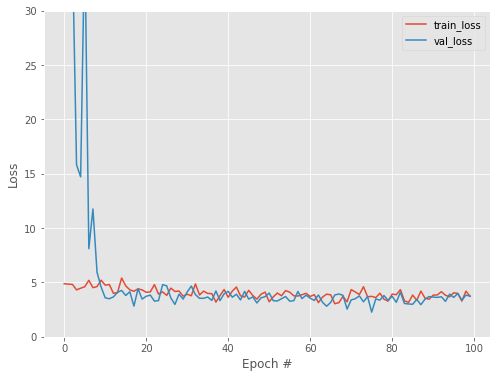

In [33]:
# Gráfica
plt.style.use("ggplot")
plt.figure(figsize = (8, 6))
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
# plt.title("Training Loss and Validation (Test) Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.ylim((0, 30))
plt.legend()
plt.show()

### Presentación de los resultados

In [27]:
# Carga del modelo
model_loaded = load_model(BASEPATH+"trained_model_32.h5")

In [54]:
predictions = []
predictions_table = []
real_values = []
for patient_id in ids_test:
    images = []
    tabs = []
    img = np.load(f'../osic-pulmonary-fibrosis-progression/trainx32_segmented_scans_128x128/{patient_id}_hu_scans.npy')
    images.append(img.T)
    tabs.append(tab_data_converted[patient_id])
       
    images,tabs = np.array(images), np.array(tabs)
    images = np.expand_dims(images, axis=-1)
    prediction = model_loaded.predict([images, tabs])[0][0]
    predictions.append(prediction)
    predictions_table.append({"Patient ID": patient_id, "Prediction": prediction})
    real_values.append(linear_decay_data[patient_id])

In [255]:
import sklearn
r2 = round(sklearn.metrics.r2_score(real_values, predictions),2)
MAE = round(sklearn.metrics.mean_absolute_error(real_values, predictions),2)
MSE = round(sklearn.metrics.mean_squared_error(real_values, predictions),2)

print(f'r2: {r2}')
print(f'MAE: {MAE}')
print(f'MSE: {MSE}')

r2: -0.34
MAE: 3.89
MSE: 27.02


In [239]:
k=9
predictions_table = pd.DataFrame(predictions_table)
random_test_patients_ids = np.random.choice(ids_test,size=k,replace=False)
random_test_patients_data = []

for patient_id in random_test_patients_ids:
    base_week = train.loc[train.Patient == patient_id].iloc[0]
    predicted_linear_decay = predictions_table.loc[predictions_table["Patient ID"] == patient_id]["Prediction"]
    week_0_fvc = int(base_week["FVC"])
    base_week_number = int(base_week["Weeks"])
    
    for index, record in train.loc[train.Patient == patient_id].iterrows():
        fvc_real = record["FVC"]
        fvc_predicted = week_0_fvc + (predicted_linear_decay * (int(record["Weeks"]) - base_week_number))
        random_test_patients_data.append({"Patient ID": patient_id, "Week": record["Weeks"], "FVC Real": fvc_real, 
                                          "FVC Predicted": fvc_predicted, "Real Linear Decay": linear_decay_data[patient_id],
                                          "Predicted Linear Decay": predicted_linear_decay})

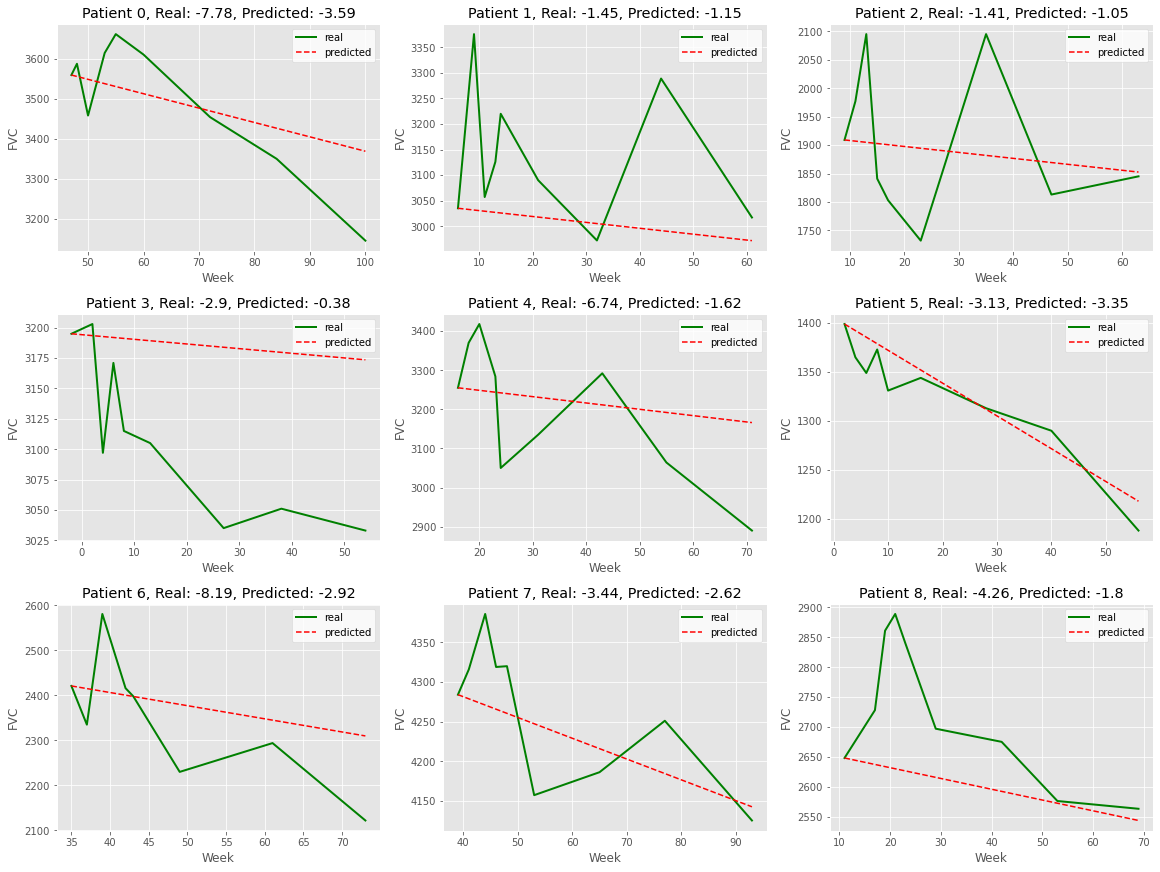

In [264]:
random_test_patients_data = pd.DataFrame(random_test_patients_data)

# Figure
f, axs = plt.subplots(3, 3, figsize = (16, 12), constrained_layout=True)

for index, ax in enumerate([[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]]):
    # Data
    patient_data = random_test_patients_data.loc[random_test_patients_data["Patient ID"] == random_test_patients_ids[index]]
    line1 = axs[ax[0],ax[1]].plot(patient_data["Week"],patient_data["FVC Real"],color="green", linewidth=2, label="real")
    line2 = axs[ax[0],ax[1]].plot(patient_data["Week"],patient_data["FVC Predicted"],color="red", linestyle='--', label="predicted")
    axs[ax[0],ax[1]].set(xlabel='Week', ylabel='FVC')
    
    # Linear decay info
    real_linear_decay = round(patient_data["Real Linear Decay"].values[0],2)
    predicted_linear_decay = round(patient_data.iloc[0]["Predicted Linear Decay"].values[0],2)
    axs[ax[0],ax[1]].set_title(f'Patient {index}, Real: {real_linear_decay}, Predicted: {predicted_linear_decay}')
    
    # Legend
    handles, labels = axs[ax[0],ax[1]].get_legend_handles_labels()
    axs[ax[0],ax[1]].legend(handles, labels, loc='upper right', facecolor="white")
    

In [236]:
predictions_table = pd.DataFrame(predictions_table)
results = []

for patient_id in ids_test:
    base_week = train.loc[train.Patient == patient_id].iloc[0]
    predicted_linear_decay = predictions_table.loc[predictions_table["Patient ID"] == patient_id]["Prediction"].values[0]
    week_0_fvc = int(base_week["FVC"])
    base_week_number = int(base_week["Weeks"])
    
    record = train.loc[train.Patient == patient_id].values[-1]
    fvc_real = record[2]
    fvc_predicted = week_0_fvc + (predicted_linear_decay * (int(record[1]) - base_week_number))
    results.append({"Patient ID": patient_id, "Week": record[1], "FVC Real": fvc_real, "FVC Predicted": fvc_predicted})

In [248]:
results = pd.DataFrame(results)
results["Difference"] = abs(results["FVC Predicted"] - results["FVC Real"])
results.sample(5)

,Patient ID,Week,FVC Real,FVC Predicted,Difference
22,ID00312637202282607344793,57,1571,1575.412987,4.412987
5,ID00167637202237397919352,66,3744,4406.754005,662.754005
25,ID00365637202296085035729,73,2122,2309.910395,187.910395
1,ID00329637202285906759848,95,2677,2735.841181,58.841181
0,ID00128637202219474716089,59,2024,2215.338921,191.338921


In [260]:
summedup = results.sum(axis=0)

In [263]:
average_treatment_duration = round(summedup["Week"] / results.shape[0])
print(f"La duración media del tratamiento es {average_treatment_duration} semanas.")

La duración media del tratamiento es 63 semanas.


In [254]:
average_difference = round(summedup["Difference"] / results.shape[0],2)
print(f"La diferencia media entre FVC real y FVC predicho para la última semana del tratamiento (MAE) es {average_difference} ml.")

La diferencia media entre FVC real y FVC predicho para la última semana del tratamiento es 185.69 ml.


In [230]:
average_difference_procentage = round(summedup["Difference"] / summedup["FVC Real"] * 100,2)
print(f"En promedio, el FVC previsto para la última semana del tratamiento difiere en un {average_difference_procentage}% del valor real.")

En promedio, el FVC previsto para la última semana del tratamiento difiere en un 7.71% del valor real.


In [253]:
r2 = sklearn.metrics.r2_score(results["FVC Real"], results["FVC Predicted"])

print(f'r2: {r2}')

r2: 0.9099684318572219
MAE: 185.68699209778399
